In [ ]:
import retinanalysis as ra
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

ra.djconnect()

[2025-06-30 12:10:38,967][INFO]: Connecting root@127.0.0.1:3306
[2025-06-30 12:10:39,007][INFO]: Connected root@127.0.0.1:3306


## Step 1: Query protocol across all experiments

In [2]:
protocols_to_query = ['movingletters', 'presentmatfiles']
experiment_query = ra.get_datasets_from_protocol_names(protocols_to_query)
display(experiment_query)


Found 1 protocols matching "movingletters":
['edu.washington.riekelab.protocols.MovingLetters']

Found 1 protocols matching "presentmatfiles":
['edu.washington.riekelab.protocols.PresentMatFiles']

Found 4 experiments, 6 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20250514C,data003,0.5,movies_images,edu.washington.riekelab.protocols.PresentMatFiles,1,20250514C/data003,PresentMatFiles,132,68,2428,3485,563
1,20250514C,data015,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250514C/data015,DR Moving Letters,132,67,2440,3497,565
2,20250527C,data010,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250527C/data010,Moving E,134,67,2460,3521,579
3,20250530C,data002,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250530C/data002,Moving Letters,139,67,2493,3560,595
4,20250429C,data007,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250429C/data007,DR moving letters,140,67,2501,3572,596
5,20250429C,data009,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250429C/data009,DR moving letters,140,67,2503,3574,596


## Select experiment and data file of interest

In [3]:
exp_name = experiment_query.loc[0, 'exp_name']
datafile_name = experiment_query.loc[0,'datafile_name']

# Create response, stim, analysis_chunk and pipeline class
response = ra.ResponseBlock(exp_name, datafile_name)
stim = ra.StimBlock(exp_name, datafile_name)
analysis_chunk = ra.AnalysisChunk(exp_name, stim.nearest_noise_chunk)
pipeline = ra.MEAPipeline(stim, response, analysis_chunk)

Fetching EIs...


  0%|          | 0/884 [00:00<?, ?it/s]

/Volumes/ExternalM2/mea_ssd/analysis/20250514C/chunk1/kilosort2.5
Fetching params...


  0%|          | 0/781 [00:00<?, ?it/s]

Fetching EIs...


  0%|          | 0/781 [00:00<?, ?it/s]


Ref clusters matched: 485
Ref clusters unmatched: 296
62.1% matched, 37.9% unmatched.


(58, 500)


Text(0, 0.5, 'Epoch')

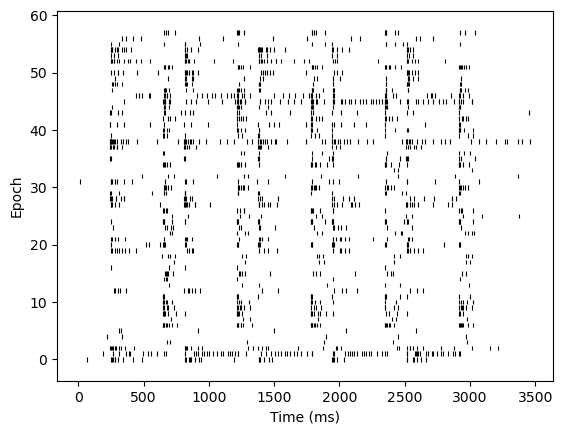

In [4]:
epoch_params = ['imageOrder']
image_order = [lst for lst in stim.df_epochs['imageOrder']]
image_order = np.array(image_order)

# display(stim.df_epochs.columns)

images_per_epoch = stim.df_epochs.loc[0,'epoch_parameters']['imagesPerEpoch']
num_epochs = len(stim.df_epochs)

# epochs_to_see = [1, 2, 5, 245, 6, 232]
# display(stim.df_epochs[['imageOrder', 'matFile']].query('epoch_index == @epochs_to_see'))

cell_of_interest = 6
cell_1_times = response.df_spike_times.query('cell_id == 1')['spike_times'].values

OffP_noise_ids = analysis_chunk.cell_params_df.query('typing_file_0 == "OffP"')['cell_id'].values
OffP_protocol_ids = [pipeline.match_dict[cell] for cell in OffP_noise_ids if cell in pipeline.match_dict.keys()]
OffP_responses = response.df_spike_times.query('cell_id == @OffP_protocol_ids')
OffP_spike_times = OffP_responses['spike_times'].values

test = np.empty((OffP_spike_times.shape[0], OffP_spike_times[0].shape[0]), dtype = object)
for i in range(test.shape[0]):
    test[i,:] = OffP_spike_times[i]

print(test.shape)
fig, ax = plt.subplots()

epochs_to_plot = np.arange(0,9)
ax.eventplot(test[:,100], color = 'k', linewidths = 0.8, linelengths = 0.8)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Epoch")





In [ ]:
print(analysis_chunk.chunk_name)
target_chunk = 'chunk2'

matches = analysis_chunk.classification_transfer(target_chunk)

In [ ]:

def get_ells(analysis_chunk, cell_types, std_scaler = 1.6, units = None):
    
    if units is not None:
        if 'microns' in units.lower():
            scale_factor = analysis_chunk.microns_per_stixel
        elif 'pixels' in units.lower():
            scale_factor = analysis_chunk.pixels_per_stixel
        else:
            scale_factor = 1
    else:
        scale_factor = 1

    ells = []
    for idx, ct in enumerate(cell_types):
        ell_dict = dict()
        cell_df = analysis_chunk.cell_params_df.query('typing_file_0 == @ct')
        rf_params = analysis_chunk.rf_params
        cell_ids = cell_df['cell_id'].values
        for id in cell_ids:
            ell_dict[id] = Ellipse(xy=(rf_params[id]['center_x']*scale_factor,
                                    rf_params[id]['center_y']*scale_factor),
                                    width = rf_params[id]['std_x']*std_scaler*scale_factor,
                                    height = rf_params[id]['std_y']*std_scaler*scale_factor,
                                    angle = rf_params[id]['rot'],
                                    facecolor= f'C{idx}', edgecolor= f'C{idx}',
                                    alpha = 0.7)
        ells.append(ell_dict)
    
    return ells, scale_factor

units = 'pixels'
cell_types = ['OffP', 'OnP', 'OffM', 'OnM', 'SBC']
all_ells, scale_factor = get_ells(analysis_chunk, cell_types, units = units)

fig, ax = plt.subplots(nrows=1, ncols = len(cell_types), figsize = (18, 12/len(cell_types)))

for idx, ct in enumerate(cell_types):
    for id in all_ells[idx]:
        ax[idx].add_patch(all_ells[idx][id])

    ax[idx].set_xlim(0,analysis_chunk.numXChecks * scale_factor)
    ax[idx].set_ylim(0,analysis_chunk.numYChecks * scale_factor)
    if units is not None:
        ax[idx].set_ylabel(units.lower())
        ax[idx].set_xlabel(units.lower())

fig.tight_layout()

